# Application: Inertial Navigation Systems

**Reference**: Chapters 15 and 16 in McClarren (2018).

## Learning Objectives

After studying this notebook, completing the activities, and asking questions in class, you should be able to:
* Apply integration techniques to realistic scenarios using Python.

In [1]:
# load libraries
import numpy as np
import matplotlib.pyplot as plt

## Appliction: Inertial Navigation Systems

<div style="background-color: rgba(0,255,0,0.05) ; padding: 10px; border: 1px solid darkgreen;"> 
<b>Home Activity</b>: Read through this problem description BEFORE attending class.
</div>

Inertial navigation systems (INS), which were originally developed to control the trajectory of rockets, have a long history.  According to an interesting article on Wikipedia, the early gyroscopic attitude control system developed by Robert Goddard (considered the father of American rocketry, and for whom Goddard Space Flight Center is named) was extended by Werner von Braun to include an accelerometer for control of the German V2 rocket used in World War II.  Basically, two gyroscopes and an accelerometer were connected through an analog computer to rudders in the rocket exhaust to keep the rocket on its desired trajectory.  Technology has improved quite a bit since then!  In addition to vastly more sophisticated systems for rockets and satellites (think about the precision necessary to actually land a Falcon 9 booster), INS is used for “dead reckoning” in submarines, aircraft, and really anything that moves: possibly even the iPhone in your pocket.  In this project you will analyze a set of data collected by Professor Dowling in an AP Physics extra credit project back when he was a teenager to determine the height between floors of a building.  It reveals both the advantages and disadvantages of the technique: the ability to infer changes in position from acceleration, and the difficulty associated with accumulated errors.

For his high school project, Professor Dowling took a small portable scale, a large brick, and a camera onto an elevator in the ASU Life Sciences Building (then the tallest building at ASU) and rode the elevator from the top of the building (5th floor) to the sub-basement (e.g., -2nd floor).  Thus, the elevator traveled a total of six floors before stopping.  Using the video camera and frame by frame analysis he determined a time series of when the scale reading changed (thus the times are not equally spaced). This data is shown below.

| Time | Weight |
|-|-|
| 2.40 | 2.765 | 
| 3.13 | 2.770 | 
| 5.27 | 2.765 | 
| 5.93 | 2.665 |
| 6.67 | 2.575 |
| 8.00 | 2.605 |
| 8.73 | 2.755 |
| 9.47 | 2.760 |
| 10.13 | 2.765 |
| 10.93 | 2.775 |
| 11.53 | 2.765 |
| 12.27 | 2.760 |
| 13.00 | 2.765 |
| 13.67 | 2.770 |
| 14.40 | 2.765 |
| 15.07 | 2.770 |
| 16.53 | 2.765 |
| 17.20 | 2.770 |
| 17.93 | 2.765 |
| 18.60 | 2.770 |
| 19.33 | 2.765 |
| 20.73 | 2.830 |
| 21.40 | 2.890 |
| 21.47 | 3.000 |
| 22.20 | 3.005 |
| 22.93 | 2.815 |
| 23.60 | 2.810 |
| 24.27 | 2.770 |
| 25.07 | 2.765 |
| 25.13 | 2.765 |



According to his report, the first four readings were prior to the elevator door shutting, thus the velocity (and acceleration) over that period should be zero.  The elevator door shut at 5.27s, and then the apparent weight of the brick starts to drop as the elevator accelerates downwards.  At the bottom the weight increases above its zero acceleration value, and then the elevator comes to rest again.  Your goal is to use this data to accurately determine the average height of a floor in the ASU building.

### Preliminary Analysis

We will start by plotting the raw data in Python.

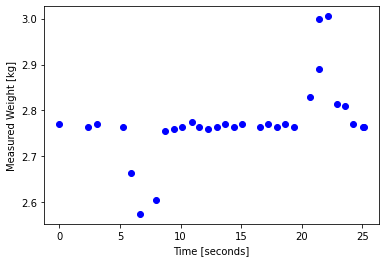

In [2]:
time = np.array([0.0,2.40,3.13,5.27,5.93,6.67,8.00,8.73,9.47,10.13,10.93,11.53,12.27,13.00,13.67,14.40,15.07,16.53,17.20,17.93,18.60,19.33,20.73,21.40,21.47,22.20,22.93,23.60,24.27,25.07,25.13])
weight = np.array([2.770,2.765,2.770,2.765,2.665,2.575,2.605,2.755,2.760,2.765,2.775,2.765,2.760,2.765,2.770,2.765,2.770,2.765,2.770,2.765,2.770,2.765,2.830,2.890,3.000,3.005,2.815,2.810,2.770,2.765,2.765])
plt.plot(time,weight,marker='o',linestyle='',color='blue')
plt.xlabel('Time [seconds]')
plt.ylabel('Measured Weight [kg]')
plt.show()

The measured weight decreases and then increases. Which conclusion can you draw from this data and your physical intuition?
1. The elevator traveled upward.
2. The elevator traveled downward.
3. Cannot tell from the data alone.
4. The elevator traveled updward and then downward, returning to its initial location.
3. The elevator traveled downward and then upward, returning to its initial location.

<div style="background-color: rgba(0,255,0,0.05) ; padding: 10px; border: 1px solid darkgreen;"> 
<b>Home Activity</b>: Store your answer as an integer in <tt>ans_elevator</tt>.
</div>

In [3]:
### BEGIN SOLUTION
ans_elevator = 2
### END SOLUTION

In [6]:
### BEGIN HIDDEN TESTS
secret_elevator = 2

assert type(ans_elevator) is int, "Your answer should be an integer."

assert ans_elevator == secret_elevator, "Try again. Do you feel heavier or lighter when an elevator starts to go down."
### END HIDDEN TESTS

We will now remove the data prior to 5.27s (but keep it for later) and subtract 5.27 from the remaining times so that your new time vector starts at zero.

In [7]:
# "clipped" time
c_time = time[3:].copy()

# "clipped" weight
c_weight = weight[3:].copy()

# subtract 5.27 seconds. Now adj_time[0] is 0.0
adj_time = c_time - 5.27

print("adj_time:",adj_time)
print("\nc_weight:",c_weight)

adj_time: [ 0.    0.66  1.4   2.73  3.46  4.2   4.86  5.66  6.26  7.    7.73  8.4
  9.13  9.8  11.26 11.93 12.66 13.33 14.06 15.46 16.13 16.2  16.93 17.66
 18.33 19.   19.8  19.86]

c_weight: [2.765 2.665 2.575 2.605 2.755 2.76  2.765 2.775 2.765 2.76  2.765 2.77
 2.765 2.77  2.765 2.77  2.765 2.77  2.765 2.83  2.89  3.    3.005 2.815
 2.81  2.77  2.765 2.765]


### Free Body Diagram & Acceleration

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Do the following with a partner.
</div>

1. Draw a free body diagram.
2. Apply Newton’s Laws of Motion.
3. Using algebra, obtain a formula to calculate acceleration using the rest $(m_0)$ and moving ($m_t$) weight of the brick.

Then using the initial weight measured at 5.27s (elevator closing weight) calculate the acceleration at each measurement time and plot it up.  Use the local g acceleration for Tempe, AZ (a Google search on “acceleration gravity Tempe Arizona” brings up a fun little Wolfram Alpha widget which yields local g for everywhere in the world – because the world is a slightly oblate spheroid, gravity is higher in northern latitudes).

We will now implement our formula to compute the acceleration at each timepoint.

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Do the following with a partner.
</div>

1. Use the initial weight measured at 5.27s (elevator closing weight) as $m_0$. Also use $g$ = = 9.80561 m/s$^2$, which is the local gravity acceleration for Tempe, AZ.
2. Calculate the acceleration of the elevator for each weight measurement.
3. Plot acceleration versus time.

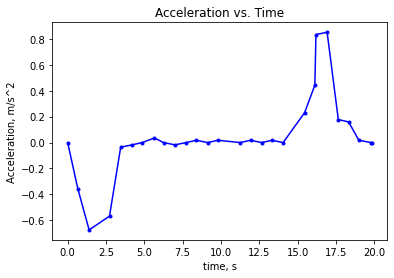

In [8]:
### BEGIN SOLUTION
w0 = c_weight[0]

# g = 9.807 # Acceleration
g = 9.80561

acc = g*(c_weight - w0)/w0

plt.plot(adj_time,acc,marker='.',linestyle='-',color='blue')
plt.title("Acceleration vs. Time")
plt.xlabel("time, s")
plt.ylabel("Acceleration, m/s^2")
plt.show()
### END SOLUTION

### Velocity

Calculate the velocity at each measurement. Remember, the velocity is just the integral of the acceleration. (Again, recall Physics 1.) Because each data point is given where the scale reading changes, an assumption is that the acceleration is constant prior to the next reading.  Thus it is appropriate to use a left edge Riemann sum to get the velocity at all subsequent times (the initial velocity is zero).  This is easiest to do with the **np.cumsum** command.  Do this, and plot up the velocity as a function of time. *Hint*: Assume initial velocity is zero.

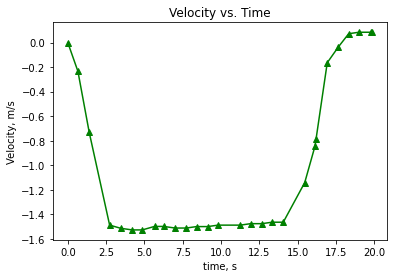

In [9]:
### BEGIN SOLUTION
v0 = 0
N = len(adj_time)-1
t_diff = adj_time[1:] - adj_time[0:N]

# original (off by 1 error)
prod = t_diff*acc[1:]

# corrected?
# prod = t_diff*acc[0:-1]

RS = np.cumsum(prod)

vel = np.asarray([v0,*RS])

plt.plot(adj_time,vel,marker='^',color='green',linestyle='-')
plt.title("Velocity vs. Time")
plt.xlabel("time, s")
plt.ylabel("Velocity, m/s")
plt.show()
### END SOLUTION

### Position

Finally, calculate the position at each measurement.  The position is the integral of the velocity.  If the acceleration were constant between each data point, then the velocity will be linear in time between each data point.  This suggests that the best way to get the change of position would be to use the trapezoidal rule.  Again taking the initial height to be a reference value of zero, do this integration and plot up the height vs. time. Use **np.cumsum** again. Report the negative of the final height, and divide it by 6 to get the average height of the floors. *Hint*: Assume initial velocity and initial height are both zero.

3.6146661293625804 m


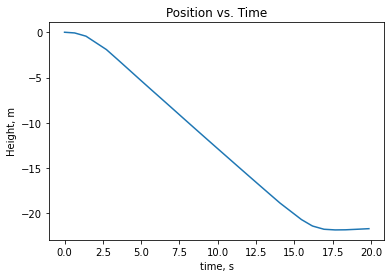

In [10]:
### BEGIN SOLUTION
h0 = 0
Nt = len(adj_time)-1
Nv = len(vel)-1
t_diff = adj_time[1:] - adj_time[0:Nt]
vel_sum = vel[1:] + vel[0:Nv]
prod = 0.5*(vel_sum*t_diff)
TR = np.cumsum(prod)

h = [v0,*TR]

plt.plot(adj_time,h)
plt.title("Position vs. Time")
plt.xlabel("time, s")
plt.ylabel("Height, m")

ave_floor_h = -1*(h[-1])/6
print(ave_floor_h,"m")

### END SOLUTION